# **RSNA-MICCAI Brain Tumor Radiogenomic Classification**

**Predict the status of a genetic biomarker important for brain cancer treatment**

***Mario Lozano Cortés - Universitat de Barcelona - Universitat Politècnica De Catalunya · Barcelona Tech***

The overarching goal of this Kaggle challenge is to develop a deep-learning-based tool to enable the automated detection of the presence of MGMT promoter methylation using MRI (magnetic resonance imaging) scans.

A malignant tumour in the brain is a life-threatening condition. Known as **glioblastoma, it's both the most common form of brain cancer in adults and the one with the worst prognosis, with median survival being less than a year. The presence of a specific genetic sequence in the tumour known as MGMT promoter methylation has been shown to be a favourable prognostic factor and a strong predictor of responsiveness to chemotherapy.** 

Currently, genetic analysis of cancer requires surgery to extract a tissue sample. Then it can take several weeks to determine the genetic characterization of the tumour. Depending upon the results and type of initial therapy chosen, subsequent surgery may be necessary. **If an accurate method to predict the genetics of cancer through imaging (i.e., radiogenomics) alone could be developed, this would potentially minimize the number of surgeries and refine the type of therapy required.** The introduction of new and customized treatment strategies before surgery has the potential to improve the management, survival, and prospects of patients with brain cancer.

In this Kaggle competition we will predict the genetic subtype of glioblastoma using MRI (magnetic resonance imaging) scans to train and test out model to detect the presence of MGMT promoter methylation. 

The organizers provided the participants with two sets of data, training and test, consisting of MRI images. The images are sorted by patient. For each patient, several images of four different scan types (FLAIR, T1w, T1wCE, T2) are available. The training set contains scans of 1010 patients. 

# **Followed approach: Transfer learning**

**In order to deal with the small number of images found in the given dataset it is decided to use a pre-trained model** previously trained on a large dataset on a large-scale image-classification task. In this way, the training can take advantage of the spatial hierarchy of features learned by the pre-trained model.

The pre-trained model used in this task is VGG16 on the ImageNet dataset (1.4 million labelled images and 1,000 different classes).

The way of using the pre-trained model is **feature extraction.** A technique that consists of using the representations learned by the pre-trained model. Hence, **an image is passed through the convolutional base of VGG16 and a new classifier is trained on top of it.** 

# **Imports and variable declarations**

This section contains the libraries used in the notebook as well as the variables relating to the parameters of the generated network.

## **Libraries used**

Code based on Tensorflow & Keras

In [1]:
import os # os functionalities
import re # regular expressions
import warnings # avoid tf warnings
import numpy as np # linear algebra
import pandas as pd # data processing
from skimage import io # image manipulation
import seaborn as sns # heatmap visualization
from matplotlib import pyplot as plt # image visualization
warnings.filterwarnings('ignore') # ignore tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # ignore tensorflow warnings

# Tensorflow & Keras & SkLearn
import keras
import tensorflow as tf 
from tensorflow.keras.metrics import AUC # area under ROC
from keras.applications.vgg16 import VGG16 # pretrained model
from sklearn.model_selection import train_test_split # divide dataset
from tensorflow.keras.preprocessing import image # preprocess a read image
from sklearn.metrics import confusion_matrix # metrics for assesing the model

## **Model variables**

Hyperparameters for the built model

In [2]:
# Paths to images
input_dir = "../input/rsna-miccai-png/train" 
target_dir = "../input/rsna-miccai-png/test"

# Model variables
epochs = 50
batch_size = 32
learning_rate = 0.0005
optimizer = "RMSprop"
data_augmentation = False
loss_function = "binary_crossentropy"

## **Data variables**

Each independent case has a dedicated folder identified by a five-digit number. Within each of these “case” folders, there are four sub-folders, each of them corresponding to each of the structural multi-parametric MRI (mpMRI) scans, in PNG format. The exact mpMRI scans included are:

- Fluid Attenuated Inversion Recovery (**FLAIR**)
- T1-weighted pre-contrast (**T1w**)
- T1-weighted post-contrast (**T1wCE**)
- T2-weighted (**T2w**)

Moreover, between the collection of images found for a single patient, the following criteria are considered to select the images to be loaded.

- **central**: Since all the images of the same patient are ordered by their id, the one in the middle is selected
- **first**: Select the first image to appear
- **all**: Select all the available images for a given patient

In [3]:
patient_mode = "all" # all - central - first 
image_modes = ["FLAIR"] # FLAIR - T1w - T1wCE - T2w

# **Data loading**

The data loading process consists of reading the paths of each of the images according to the selected criteria, dividing them into training, validation and test sets and creating data generators for each of them.

In [4]:
def prepare_data(image_mode, patient_mode):
    """
    This function prepares the paths to the images and gets the labels for each image
    :parameter image_mode: Type of the images to be loaded (FLAIR - T1w - T1wCE - T2w)
    :parameter patient_mode: Criteria for selecting the specific images of a patient that are going to be used
    :return input_img_paths: List of paths to the images
    :return labels: List of labels for each image
    """

    # Get path to the training images
    input_img_paths_patients = sorted([
        os.path.join(input_dir, fname + "/" + image_mode) 
        for fname in os.listdir(input_dir)
        if os.path.exists(os.path.join(input_dir, fname + "/" + image_mode))])

    # Get images id's by a specific criteria
    input_img_paths = []
    for patient in input_img_paths_patients:
        images_id = x = [int(re.findall(r'\d+', x)[0]) for x in os.listdir(patient)] # Get all image ids
        '''
        Images for an specific patient are selected following one of these criteria
        - central: Since all the images of the same patient are ordered by their id, the one in the middle is seletected
        - first: Select the first one to appear
        - all: Select all the available images for a given patient
        '''
        if patient_mode == "central":  # Get middle image
            index_central_image = min(images_id) + round((max(images_id) - min(images_id))/2)
            path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
            if os.path.exists(path): input_img_paths.append(path)
        if patient_mode == "first": # Get first image
            index_central_image = min(images_id) 
            path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
            if os.path.exists(path): input_img_paths.append(path)
        if patient_mode == 'all': # Add all of the available images
            for image in images_id:
                path = os.path.join(patient, "Image-" + str(image) + ".png")
                if os.path.exists(path): input_img_paths.append(path)

    # Read csv labels
    df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')

    # Obtain pure labels
    labels = []
    for img_path in input_img_paths:
        labels.append(df.loc[df['BraTS21ID'] == int(re.findall(r'\d+', img_path)[0])]['MGMT_value'].iloc[0])
        
    return input_img_paths, labels

In [5]:
def split_data(input_img_paths, labels, verbose=True):
    """
    This function splits the data between the training, validation and test sets
    :parameter input_img_paths: List of paths to the images
    :parameter labels: List of labels for each image
    :return train_df: Dataframe containing paths and labels of the training set
    :return val_df: Dataframe containing paths and labels of the validation set
    :return test_df: Dataframe containing paths and labels of the test set
    """
    
    # Split data into train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(input_img_paths, labels, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42) # 0.111*0.9 = 0.1

    # Check amounts of data in each split
    if verbose:
        print(f"Training samples: {str(len(X_train))}\nValidation samples: {str(len(X_val))}\nTest samples: {str(len(X_test))}\n")

    # Create dataframes for keras flow_from_dataframe
    data = {'id': X_train, 'label': [str(x) for x in y_train]}
    train_df = pd.DataFrame(data)

    data = {'id': X_val, 'label': [str(x) for x in y_val]}
    val_df = pd.DataFrame(data)

    data = {'id': X_test, 'label': [str(x) for x in y_test]}
    test_df = pd.DataFrame(data)
    
    return train_df, val_df, test_df

In [6]:
def get_data_generators(train_df, val_df, test_df, data_augmentation=False):
    """
    This function loads the dataset from dataset folder and returns the image generators associated
    :parameter train_df: Dataframe with paths to training images and labels
    :parameter val_df: Dataframe with paths to validation images and labels
    :parameter test_df: Dataframe with paths to test images and labels
    :parameter data_augmentation: Boolean indicating whether to include or not data augmentation
    :return train_generator: Training generator
    :return val_generator: Validation generator
    :return test_generator: Testing generator
    """

    # Create a data generator
    if data_augmentation:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                        rotation_range=20,
                                                                        width_shift_range=0.1,
                                                                        height_shift_range=0.1,
                                                                        zoom_range=0.2,
                                                                        horizontal_flip=True)
    else:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
        
    datagen_val_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # Load and iterate training dataset
    train_generator=datagen_train.flow_from_dataframe(dataframe=train_df, x_col="id", y_col="label", 
                                                      class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate validation dataset
    val_generator=datagen_val_test.flow_from_dataframe(dataframe=val_df, x_col="id", y_col="label", 
                                                       class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate test dataset
    test_generator=datagen_val_test.flow_from_dataframe(dataframe=test_df, x_col="id", y_col="label", 
                                                        class_mode="binary", batch_size=batch_size, target_size=(224, 224))

    return train_generator, val_generator, test_generator

In [7]:
def load_dataset(image_mode, patient_mode, data_augmentation):
    """
    This function loads the dataset for a given image mode
    :parameter image_mode: Type of the images to be loaded (FLAIR - T1w - T1wCE - T2w)
    :parameter patient_mode: Criteria for selecting the specific images of a patient that are going to be used
    :parameter data_augmentation: Boolean indicating whether to include or not data augmentation
    :return train_generator: Training generator
    :return val_generator: Validation generator
    :return test_generator: Testing generator
    """
    
    input_img_paths, labels = prepare_data(image_mode, patient_mode)
    train_df, val_df, test_df = split_data(input_img_paths, labels)
    train_generator, val_generator, test_generator = get_data_generators(train_df, val_df, test_df, data_augmentation)
    
    return train_generator, val_generator, test_generator

## **Data visualization**

Visualisation of selected image types with positive and negative examples

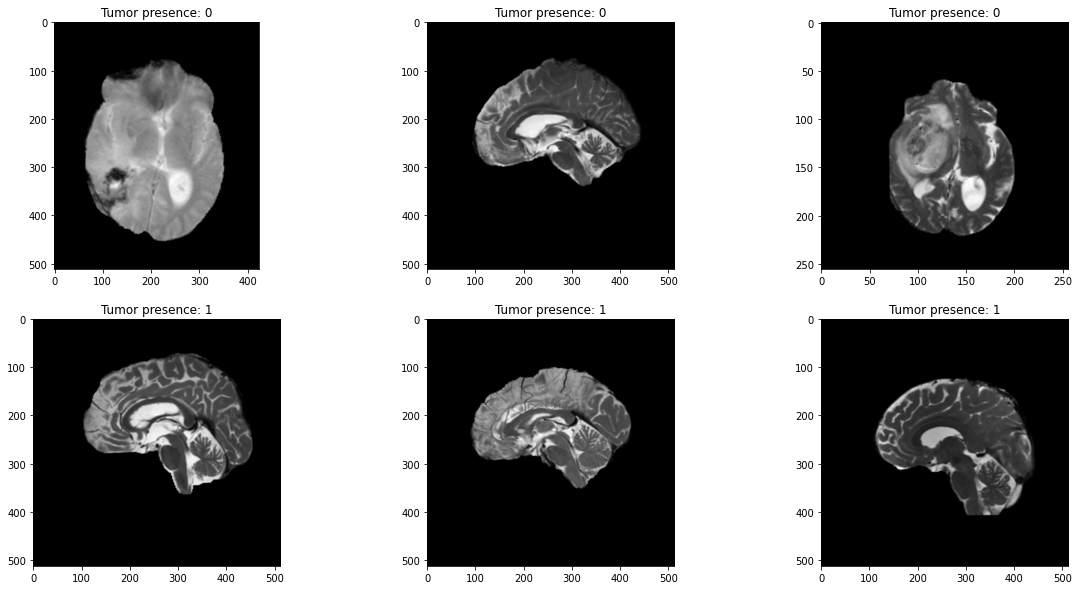

In [8]:
for visualization in ["T2w"]:

    # Load images
    input_img_paths, labels = prepare_data(visualization, "central")
    train_df, val_df, test_df = split_data(input_img_paths, labels, verbose=False)

    samples = 3 # Number of samples to select of each label

    # samples are obtained for no tumor and tumor
    selected = pd.concat([train_df[train_df.label.eq('0')].sample(samples), train_df[train_df.label.eq('1')].sample(samples)])

    # Create figure
    fig = plt.figure(figsize=(20, 10))

    # Setting values to rows and column variables
    rows = 2
    columns = samples

    # Plot images
    for element in range(0, len(selected)):
        fig.add_subplot(rows, columns, element + 1)
        plt.imshow(io.imread(list(selected['id'])[element]), cmap='gray')
        plt.title(f"Tumor presence: {list(selected['label'])[element]}")
        plt.savefig(f'{visualization}_visualization.pdf')

As can be seen, **in addition to the lack of data, one of the great difficulties to be faced in this challenge is the lack of uniformity between the images. For the same type of scan, we find images of the brain taken from multiple perspectives (frontal, transversal and lateral)**. This fact complicates the training process and is therefore an obstacle to be overcome.

# **Model definition**

**Frozen VGG16 Convolutional Base + Custom Classifier**

In [9]:
def define_model(verbose=False):
    """
    This function defines the convolutional neural network model to be used
    :return train_generator: Training generator
    """
    
    # Free up RAM in case the model definition cells were run multiple times
    keras.backend.clear_session()

    # Build model
    vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights=vgg16_weight_path)
    #base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

    # Make sure that the base_model is running in inference mode here, by passing `training=False`
    base_model.trainable = False

    # Define model structure
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)
    # Dense classifier for binary classification
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dense(16, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    if verbose:
        model.summary()

    return model

In [10]:
# Choose optimizer - SGD - RMSprop - Adam
if optimizer == "SGD": 
    fit_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=learning_rate/epochs)
elif optimizer == "RMSprop":
    fit_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=learning_rate/epochs)
else: 
    fit_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7, amsgrad=True)

# **Model training**

In this section the model is trained with the parameters selected in the *Imports and variable declarations* section.

In [11]:
def train_model(model, fit_optimizer, loss_function, epochs, train_generator, val_generator, image_mode):
    """
    This function trains a given model with the parameters specified the dataset for a given image mode
    :parameter model: Keras model to be trained 
    :parameter fit_optimizer: Optimizers to compute the moving average and overwrite the model variables at desired time
    :parameter loss_function: Objective function
    :parameter epochs: Number of episodes to trained the model
    :parameter training_generator: Training generator
    :parameter val_generator: Validation generator
    :parameter image_mode: Type of the images to be loaded (FLAIR - T1w - T1wCE - T2w)
    :return model: Keras model trained
    :return model_history: Model training history 
    """
    
    # Free up RAM in case the model definition cells were run multiple times
    keras.backend.clear_session()
    
    # Configure the model for training.
    model.compile(optimizer=fit_optimizer, loss=loss_function, metrics=['accuracy', AUC()])

    # Safe best model and Early Stopping
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]

    # Train the model, doing validation at the end of each epoch.
    model_history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)
    
    return model, model_history

In [12]:
# Store models, scores, training histories and test generators into dictionaries
models = {}
scores = {}
model_histories = {}
test_generators = {}

# Train a model for each image_mode available
for image_mode in image_modes:
    print(f"\nTraining with: {image_mode} images\n")
    
    # Prepare and load data
    train_generator, val_generator, test_generator = load_dataset(image_mode, patient_mode, data_augmentation)

    # Define model
    model = define_model()

    # Train model
    model, model_histories[image_mode] = train_model(model, fit_optimizer, loss_function, epochs, train_generator, val_generator, image_mode)
    models[image_mode] = model
    
    # Evaluate the model
    test_generators[image_mode] = test_generator
    test_generator.reset()
    scores[image_mode] = model.evaluate(test_generator, verbose=0)
    print(f"\nLoss: {str(scores[image_mode][0])} \nAccuracy on test: {str(scores[image_mode][1])}\nAUC: {str(scores[image_mode][2])}\n")


Training with: FLAIR images

Training samples: 42950
Validation samples: 5363
Test samples: 5369

Found 42950 validated image filenames belonging to 2 classes.
Found 5363 validated image filenames belonging to 2 classes.
Found 5369 validated image filenames belonging to 2 classes.
Epoch 1/50
1343/1343 [==============================] - 371s 268ms/step - loss: 0.6685 - accuracy: 0.5981 - auc: 0.5819 - val_loss: 0.6746 - val_accuracy: 0.5974 - val_auc: 0.6078
Epoch 2/50
1343/1343 [==============================] - 169s 126ms/step - loss: 0.6608 - accuracy: 0.6065 - auc: 0.6085 - val_loss: 0.6633 - val_accuracy: 0.6053 - val_auc: 0.6184
Epoch 3/50
1343/1343 [==============================] - 160s 119ms/step - loss: 0.6539 - accuracy: 0.6131 - auc: 0.6281 - val_loss: 0.6531 - val_accuracy: 0.6164 - val_auc: 0.6361
Epoch 4/50
1343/1343 [==============================] - 160s 119ms/step - loss: 0.6487 - accuracy: 0.6185 - auc: 0.6402 - val_loss: 0.6546 - val_accuracy: 0.6155 - val_auc: 0.64

# **Model evaluation**

In this section, the following evaluation metrics are calculated:

- **Accuracy**: Denotes the percent of instances that are accurately classified. This metric calculates the ratio between the amount of adequately classified images and the total number of images in the test set. (Correct predictions / Number of predictions).

- **AUC. Area Under the ROC Curve**: A ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate and False Positive Rate. A ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

Moreover, the following graphs are generated:

- **Accuracy and loss evolution during training**

- **Confusion matrix**: Table that summarizes the number of correct and incorrect predictions that a classification model made.

*The main metric used in the challenge is AUC an hence, it will be given the most importance.*

In [13]:
# Get best model
best_model = list(scores.keys())[0]
for image_mode in scores:
    if scores[image_mode][2] > scores[best_model][2]:
        best_model = image_mode
        
# Serialize and save model to json
model_json = models[best_model].to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize and save weights to HDF5
models[best_model].save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


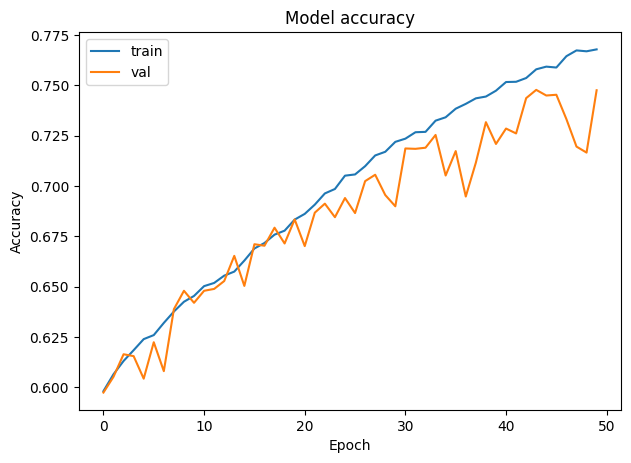

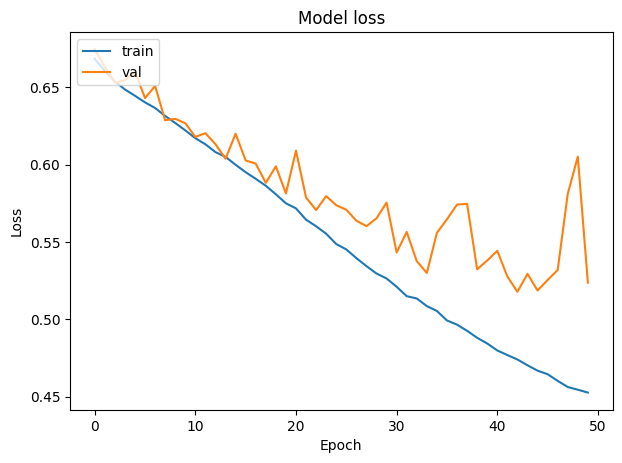

In [14]:
# Accuracy plot to show the evolution of the training process of the best model
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(model_histories[best_model].history['accuracy'])
plt.plot(model_histories[best_model].history['val_accuracy'])
plt.title(f'Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'Brain_Tumor_accuracy.pdf')
plt.show()
plt.close()

# Loss plot to show the evolution of the training process of the best model
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(model_histories[best_model].history['loss'])
plt.plot(model_histories[best_model].history['val_loss'])
plt.title(f'Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'Brain_Tumor_loss.pdf')
plt.show()
plt.close()

The loss is used to know when network training has to stop. Therefore, **attention should be paid to when the generalisation error of the network increases, i.e. when the validation loss stops improving while the training loss continues to improve.**

In [15]:
# Evaluate the model
test_generators[best_model].reset()
score = models[best_model].evaluate(test_generators[best_model], verbose=0)
print(f"Loss: {str(score[0])} \nAccuracy on test: {str(score[1])}\nAUC: {str(score[2])}")

Loss: 0.5253309011459351 
Accuracy on test: 0.7384988069534302
AUC: 0.8227965235710144


In [16]:
# Assign most probable label to predictions
test_generators[best_model].reset()
pred = models[best_model].predict(test_generators[best_model], verbose=0)
predicted_class_indices = np.round(pred)

# Get class labels
target_names = (test_generators[best_model].class_indices).keys()

# Get confusion matrix
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
cf_matrix = confusion_matrix(np.array(test_generators[best_model].classes), predicted_class_indices)
heatmap = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues', cbar=True, square=False, 
                      annot_kws={"fontsize":32}, xticklabels=target_names, yticklabels=target_names)
fig = heatmap.get_figure()
plt.savefig(f'Brain_Tumor_confusion_matrix.pdf')
plt.close()

# **Challenge submission**

This code generates predictions on the public test data of the challenge and generates the submission file.

In [17]:
# Get path to the training images
input_img_paths_patients = sorted([
    os.path.join("../input/rsna-miccai-png/test", fname + "/" + "FLAIR") 
    for fname in os.listdir("../input/rsna-miccai-png/test")
    if os.path.exists(os.path.join("../input/rsna-miccai-png/test", fname + "/" + "FLAIR"))])

# Get images id's for central criteria
input_img_paths = []
for patient in input_img_paths_patients:
    images_id = x = [int(re.findall(r'\d+', x)[0]) for x in os.listdir(patient)] # Get all image ids
    
    # Get central image for patient
    index_central_image = min(images_id) + round((max(images_id) - min(images_id))/2)
    path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
    if os.path.exists(path): input_img_paths.append(path)

# Make predictions
results = []
for img_input in input_img_paths:
    img = image.load_img(img_input, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_batch *= 255.0/img_batch.max() 
    results.append(models[best_model].predict(img_batch, verbose=0)[0][0])

# Store predictions in suitable format for the challenge submission
subm = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
subm['MGMT_value'] = results
subm.to_csv("submission.csv", index=False)

# **Results, critical commentary and discussion**

Throughout this notebook, a VGG16 network with a custom classifier has been implemented with different metrics that allow us to know in depth the quality of the proposed solution. The use of the different parameters is not the result of chance, but of a process of rigorous experimentation and problem-solving. Thus, the effect of the following parameters on the network has been tested. *(All of the following metrics shown are AUC)*.

* **Pre-trained model**: Pre-trained model previously trained on a large dataset on a large-scale image-classification task. **In this notebook the models tested were VGG16 and VGG19, obtaining the best overall with VGG16 on the ImageNet dataset (1.4 million labelled images and 1,000 different classes)**.

* **Batch size**: The number of samples processed before the model updates its parameters. Thus, the smaller the batch size the faster convergence to optimal minima, since the model starts learning before having to see all the train data. It should be a “point” between 1 and the whole dataset batch size, that leads to the best generalization. Usually, a lower batch size will lead to better test accuracy, however, it will also cause more instabilities in validation depending on how noisy the data are in every batch. **In this notebook, the values tested were 16 - 32 - 64 - 128, obtaining the best overall result with 32.**

* **Data augmentation.**  The use of data augmentation has not improved the network's performance. This may be due to the fact that the data augmentation is not good enough because, for example, it is too aggressive. Thus, when generating the variations of the existing data, the network does not generalise the problem properly and the predictions in tests are much worse. Therefore, we have tried to modify the data augmentation without obtaining the desired results. **Best overall result without data augmentation**.

* **Loss function**: As part of the optimization algorithm, the error for the current state of the model must be estimated repeatedly. This requires the choice of an error function of the model so that the weights can be updated to reduce the loss on the next evaluation. **In this notebook, we use binary crossentropy**. Binary crossentropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions. The score is minimized and a perfect cross-entropy value is 0.

* **Optimizer**: **It determines how the network will be updated based on the loss function**. Optimizers are algorithms used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses. The chosen one based on experimentation on the problem is **RMSProp**, nevertheless, the ones tested in this notebook are 

    * **SGD** - Stochastic gradient descent. Classic method.
    * **RMSProp** - Root Mean Square Propagation maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on noisy problems.
    * **Adam** - Extension of stochastic gradient descent. The name Adam is derived from adaptive moment estimation.  Empirical results demonstrate that Adam works well in practice and compares favourably to other stochastic optimization methods.

* **Learning rate**: Learning rate determines the step size at each iteration while moving toward a minimum of a loss function. A value of 0,0005 is chosen in this notebook.

* **Number of epochs**: Number of complete passes of the training data through the network. With the chosen set of parameters 50 achieve the best overall result.

* **Structural multi-parametric MRI scans**: Fluid Attenuated Inversion Recovery (FLAIR), T1-weighted pre-contrast (T1w), T1-weighted post-contrast (T1Gd), T2-weighted (T2). **The best overall result was obtained with Fluid Attenuated Inversion Recovery (FLAIR) images**.


* **Image criteria**: Between the collection of images found for a single patient, the considered criteria to select the images to be loaded are 'central', 'first' and 'all'. **The best overall result was obtained with the 'all' criteria**. The explanation for this is most likely related to the poorness of the dataset. The 'all' criteria takes a bigger amount of images although some of them are extremely poor quality ones.


**Thus, in the end, the parameters that obtain the best results are: 32 Batch size, 0,0005 Learning rate, RMSProp optimizer, Binary crossentropy loss, No data augmentation, 50 epoch, Fluid Attenuated Inversion Recovery (FLAIR) scan and 'all' criteria. The best result obtained is an AUC of 0.823.**

**This result is considered to be very good taking into account that in the challenge ranking it would have been placed in position 12 of 1556 participants, as can be observed from the public test data leaderboard: https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/leaderboard?tab=public**

# **Future work. What have others done?**

Contrary to what top solutions look like, the winner’s final solution was one of the very first baselines he started with. There was no model ensembling, no complex/big models, and no sophisticated training techniques. So it’s very curious to know why some more complex ideas are not working. The winning model looks like this in the own words of the winner:

- 3DCNN 
- Resnet10 
- Binary Cross Entropy loss 
- Adam optimizer 
- 15 epochs 
- LR: epoch 1 to 10; lr = 0.0001 | epoch 10 to 15 lr=0.00005 
- Batch size - 8
- "Best central image trick” to build 3D images. Each independent case has a different number of images for all the MRI scans. Using all the scans will confuse the model in learning the spatial dependence of the brain pixels that are not useful in our case. People took the central image (the image in the middle). Nevertheless, using the biggest image as a central image (the image that contains the largest brain cutaway view)  slightly improves the performance. 

**The result obtained by this proposal is an AUC of 0.621 with the private test set while the solution proposed in this notebook reaches 0.823 with the public test set. Thus, as they are different test sets, we cannot directly compare these results. However, we can say that the result obtained is very good as it is positioned in the top 15 of the results with the public test set among 1556 participants. Nevertheless, there is always room for improvement. Thus, the main lesson we can learn from the winner of the private test set is that it is important to properly treat the representation** we are passing to the model. We have to remember that each of the images of each patient are from different perspectives and, therefore, it is difficult for the model to understand the spatial dependencies in such a sparse dataset. Thus, the "best central image trick" used by the winner creates a 3D representation of the images that allows the model to understand the spatial relationships that exist in the brain scans.

On the other hand, other participants use more complex models, as is the case for the second winner (AUC of 0.618 in the private test set). This participant uses a **CNN-LSTM architecture that makes use of all 4 types of images simultaneously**. Thus obtaining more information.

Finally, other participants, such as the third one (AUC of 0.617 in the private test set), employ transfer learning in a similar way to us but adding an **ensemble of each of the models obtained for each of the available image types.**

In summary, it is considered that **it is possible to improve the results by testing more different models that improve the spatial representations of the different images given the poor quality characteristics of the dataset.**


# **Annex: Results**


Results-Brain-Tumor-Radiogenomic-Classification    
    
--------------- Test 1 ---------------    
    
Network = VGG16-128-64-32-1    
Epochs = 7    
Batch Size = 64    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Baseline    
    
AUC test: 0.653    
    
--------------- Test 2 ---------------    
    
Network = VGG16-128-64-32-1    
Epochs = 7    
Batch Size = 128    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Higher batch size    
    
AUC test: 0.645    
    
--------------- Test 3 ---------------    
    
Network = VGG16-128-64-32-1    
Epochs = 7    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Smaller batch size    
    
AUC test: 0.649    
    
    
--------------- Test 4 ---------------    
    
Network = VGG16-128-64-32-1    
Epochs = 15    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Trained on more epochs    
    
AUC test: 0.664    
    
--------------- Test 5 ---------------    
    
Network = VGG16-128-64-32-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Trained on more epochs    
    
AUC test: 0.666    
    
--------------- Test 6 ---------------    
    
Network = VGG16-128-64-32-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "Adam"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Change optimizer    
    
AUC test: 0.5     
    
--------------- Test 7 ---------------    
    
Network = VGG16-128-64-32-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "SGD"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Change optimizer    
    
AUC test: 0.624    
    
--------------- Test 8 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Increase network depth    
    
AUC test: 0.667    
    
--------------- Test 9 ---------------    
    
Network = VGG16-256-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Increase network depth    
    
AUC test: 0.666    
    
--------------- Test 10 ---------------    
    
Network = VGG19-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: VGG19    
    
AUC test: 0.5    
    
--------------- Test 11 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T2w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = True    
split = 90-10-10    
Comment: Data augmentation    
    
AUC test: 0.5    
    
--------------- Test 12 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "FLAIR"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Change type of images    
    
AUC test: 0.686    
    
--------------- Test 13 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T1w"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Change type of images    
    
AUC test: 0.5    
    
--------------- Test 14 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "all"    
image_mode = "T1wCE"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Change type of images    
    
AUC test: 0.5    
    
--------------- Test 15 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 25    
Batch Size = 16    
LR = 0.01    
patient_mode = "all"    
image_mode = "FLAIR"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Lower batch size    
    
AUC test: 0.5    
    
--------------- Test 16 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "central"    
image_mode = "FLAIR"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Change image mode    
    
AUC test: 0.5    
    
--------------- Test 17 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.01    
patient_mode = "first"    
image_mode = "FLAIR"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Change image mode    
    
AUC test: 0.5    
    
--------------- Test 18 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 25    
Batch Size = 32    
LR = 0.005    
patient_mode = "all"    
image_mode = "FLAIR"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Lower learning rate    
    
AUC test: 0.696    
    
--------------- Test 19 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 30    
Batch Size = 32    
LR = 0.001    
patient_mode = "all"    
image_mode = "FLAIR"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Lower learning rate + more epochs    
    
AUC test: 0.761    
    
--------------- Test 20 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 50    
Batch Size = 32    
LR = 0.001    
patient_mode = "all"    
image_mode = "FLAIR"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: More epochs    
    
AUC test: 0.773    
    
--------------- Test 21 ---------------    
    
Network = VGG16-128-64-32-16-1    
Epochs = 40    
Batch Size = 32    
LR = 0.0005    
patient_mode = "all"    
image_mode = "FLAIR"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: Lower learning rate  + less epochs    
    
AUC test: 0.779    
    
**--------------- Test 22 ---------------**    

**Network = VGG16-128-64-32-16-1    
Epochs = 50    
Batch Size = 32    
LR = 0.0005    
patient_mode = "all"    
image_mode = "FLAIR"    
optimizer = "RMSprop"    
loss_function = "binary_crossentropy"    
data_augmentation = False    
split = 90-10-10    
Comment: More epochs**    
    
**AUC test: 0.823** 